In [10]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd

In [178]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [54]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

AttributeError: 'list' object has no attribute 'max'

In [ ]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
#or
inspector =inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [48]:
# Save references to each table
measurement = Base.classes.measurement 
station = Base.classes.station 

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [319]:
print(inspector.get_table_names())

['measurement', 'station']


In [348]:
#posted for self reference
print("Measurement columns")
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    
print("...")
print("Station columns:")
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

Measurement columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
...
Station columns:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [289]:
# Calculate the date 1 year ago from the last data point in the database

date_as_result = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date = date_as_result[0]

dt_last_date= dt.datetime.strptime(last_date, '%Y-%m-%d')

year_before = (dt_last_date) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_year_before = session.query(measurement.date, measurement.prcp).filter(measurement.date>=year_before).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_year_before, columns = ["date","prcp"]).set_index('date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by=['date'])
prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


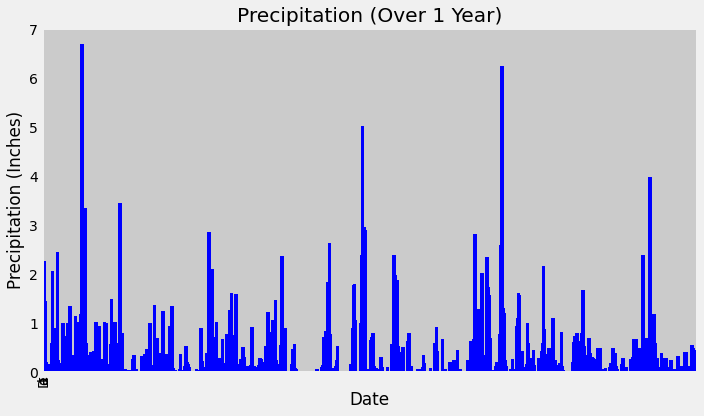

In [302]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = prcp_df.plot(kind="bar", title="Precipitation (Over 1 Year)", width=12, figsize=(10,6), color="b",legend=False)
prcp_plot.set_xlabel("Date")
prcp_plot.set_ylabel("Precipitation (Inches)")
prcp_plot.set_xticklabels('Date') 
plt.tight_layout()


In [304]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [312]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station.station).count()
station_count

9

In [380]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activity_count = session.query(measurement.station, func.count()).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active = activity_count[0][0]
print(f"Most active station is {most_active}")
print("...")
print("Station activity by descending order:")
for station, count in activity_count:
    print(station,count)

Most active station is USC00519281
...
Station activity by descending order:
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [446]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active)
print(f"Lowest recorded temperature at Station {most_active} is {low_temp[0][0]}")

high_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active)
print(f"Highest recorded temperature at Station {most_active} is {high_temp[0][0]}")

avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active).all()
avg_temp = round(avg_temp[0][0], 2)
print(f"Average temperature at Station {most_active} is {avg_temp}")

Lowest recorded temperature at Station USC00519281 is 54.0
Highest recorded temperature at Station USC00519281 is 85.0
Average temperature at Station USC00519281 is 71.66


In [422]:
# Choose the station with the highest number of temperature observations.
temp_count = session.query(measurement.station, func.count(measurement.tobs)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.tobs).desc()).all()
temp_count_station= temp_count[0][0]
temp_count_station

'USC00519281'

In [435]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
previous_temps = session.query(measurement.tobs).filter(measurement.station == temp_count_station and measurement.date >= year_before)
last_year_temp_df = pd.DataFrame(previous_temps)
last_year_temp_df.head()

,tobs
0,70.0
1,62.0
2,74.0
3,75.0
4,74.0


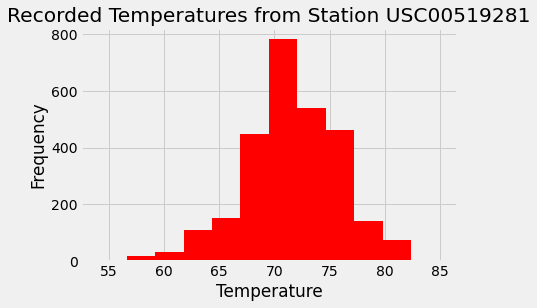

In [447]:
temp_plot = last_year_temp_df.plot(kind="hist", bins=12, title=f"Recorded Temperatures from Station {temp_count_station}", color="r",legend=False)
temp_plot.set_xlabel("Temperature")
temp_plot.set_ylabel("Frequency")
temp_plot.grid(True)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
